# Lecture 4: Class demo

## Imports

In [1]:
import sys
import numpy as np
import pandas as pd
import os

sys.path.append(os.path.join(os.path.abspath(".."), (".."), "code"))

import matplotlib.pyplot as plt

import panel as pn
from panel import widgets
from panel.interact import interact

pn.extension()

from sklearn.svm import SVC
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from matplotlib.figure import Figure

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import mglearn

from sklearn.dummy import DummyClassifier
from plotting_functions import *
from sklearn.model_selection import cross_validate, train_test_split
from utils import *
DATA_DIR = os.path.join(os.path.abspath(".."), (".."), "data/")
pd.set_option("display.max_colwidth", 200)

In [2]:
import torch
from torchvision import datasets, models, transforms, utils
from PIL import Image
from torchvision import transforms
from torchvision.models import vgg16
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [3]:
import random
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
set_seed(seed=42)   

To run this demo locally, you'll need to install `panel` in the cpsc330 environment. 

```
conda install panel watchfiles
```

<br><br>

## Decision boundaries playground

In this interactive playground, you will investigate how various algorithms create decision boundaries to distinguish between Iris flower species using their sepal length and width as features. By adjusting the parameters, you can observe how the decision boundaries change, which can result in either overfitting (where the model fits the training data too closely) or underfitting (where the model is too simplistic).

- With **k-Nearest Neighbours ($k$-NN)**, you'll determine how many neighboring flowers to consult. Should we rely on a single nearest neighbor? Or should we consider a wider group? 

- With **Support Vector Machine (SVM)** using the RBF kernel, you'll tweak the hyperparameters `C` and `gamma` to explore the tightrope walk between overly complex boundaries (that might overfit) and overly broad ones (that might underfit).
  
- With **Decision trees**, you'll observe the effect of `max_depth` on the decision boundary. 

Observe the process of refining decision boundaries, one parameter at a time! 

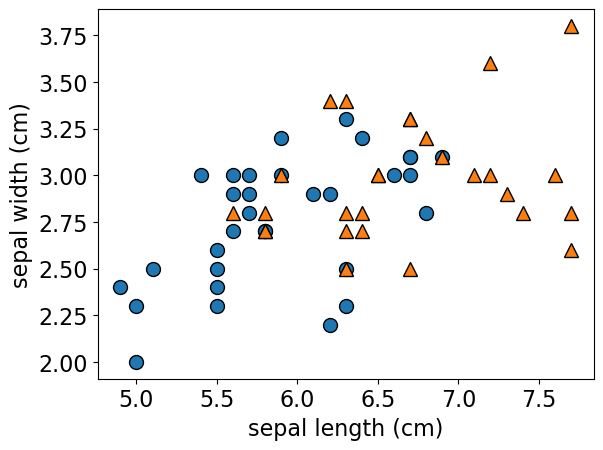

In [4]:
# Load dataset and preprocessing
iris = load_iris(as_frame=True)
iris_df = iris.data
iris_df['species'] = iris.target
iris_df = iris_df[iris_df['species'] > 0]
X, y = iris_df[['sepal length (cm)', 'sepal width (cm)']], iris_df['species']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=123)

mglearn.discrete_scatter(
    X_train["sepal length (cm)"], X_train["sepal width (cm)"], y_train, s=10
);
# Setting the labels for the x-axis and y-axis
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')

plt.show()

In [5]:
X_train

,sepal length (cm),sepal width (cm)
70,5.9,3.2
139,6.9,3.1
87,6.3,2.3
109,7.2,3.6
51,6.4,3.2
124,6.7,3.3
61,5.9,3.0
129,7.2,3.0
64,5.6,2.9
104,6.5,3.0


In [17]:
# Common plot settings
def plot_results(model, X_train, y_train, title, ax):
    mglearn.plots.plot_2d_separator(model, X_train.values, fill=True, alpha=0.4, ax=ax);
    mglearn.discrete_scatter(
        X_train["sepal length (cm)"], X_train["sepal width (cm)"], y_train, s=6, ax=ax
    );
    ax.set_xlabel("sepal length (cm)", fontsize=10);
    ax.set_ylabel("sepal width (cm)", fontsize=10);
    train_score = np.round(model.score(X_train.values, y_train), 2)
    test_score = np.round(model.score(X_test.values, y_test), 2)
    ax.set_title(
        f"{title}\n train score = {train_score}\ntest score = {test_score}", fontsize=8
    );
    pass


# Widgets for SVM, k-NN, and Decision Tree
c_widget = pn.widgets.FloatSlider(
    value=1.0, start=1, end=5, step=0.1, name="C (log scale)"
)
gamma_widget = pn.widgets.FloatSlider(
    value=1.0, start=-3, end=5, step=0.1, name="Gamma (log scale)"
)
n_neighbors_widget = pn.widgets.IntSlider(
    start=1, end=40, step=1, value=5, name="n_neighbors"
)
max_depth_widget = pn.widgets.IntSlider(
    start=1, end=20, step=1, value=3, name="max_depth"
)


# The update function to create the plots
def update_plots(c, gamma=1.0, n_neighbors=5, max_depth=3):
    c_log = round(10**c, 2)  # Transform C to logarithmic scale
    gamma_log = round(10**gamma, 2)  # Transform Gamma to logarithmic scale

    fig = Figure(figsize=(9, 3))
    axes = fig.subplots(1, 3)

    models = [
        SVC(C=c_log, gamma=gamma_log, random_state=42),
        KNeighborsClassifier(n_neighbors=n_neighbors),
        DecisionTreeClassifier(max_depth=max_depth, random_state=42),
    ]
    titles = [
        f"SVM (C={c_log}, gamma={gamma_log})",
        f"k-NN (n_neighbors={n_neighbors})",
        f"Decision Tree (max_depth={max_depth})",
    ]
    for model, title, ax in zip(models, titles, axes):
        model.fit(X_train, y_train)
        plot_results(model, X_train, y_train, title, ax);
    # print(c, gamma, n_neighbors, max_depth)
    return pn.pane.Matplotlib(fig, tight=True);


# Bind the function to the panel widgets
interactive_plot = pn.bind(
    update_plots,
    c=c_widget.param.value_throttled,
    gamma=gamma_widget.param.value_throttled,
    n_neighbors=n_neighbors_widget.param.value_throttled,
    max_depth=max_depth_widget.param.value_throttled,
)

# Layout the widgets and the plot
dashboard = pn.Column(
    pn.Row(c_widget, n_neighbors_widget),
    pn.Row(gamma_widget, max_depth_widget),
    interactive_plot,
)

# Display the interactive dashboard
dashboard

ValueError: Found array with dim 4. SVC expected <= 2.

For this demonstration I'm using a subset of [Kaggle's Animal Faces dataset](https://www.kaggle.com/datasets/andrewmvd/animal-faces). I've put this subset in our [course GitHub repository](https://github.com/UBC-CS/cpsc330-2024W2/tree/main/lectures/data/animal_faces). 

The code in this notebook is a bit complicated and you are not expected to understand all the code. 

<br><br>

## Image classification using KNNs and SVM RBF

Let's proceed with reading the data. Since we don't have tabular data, we are using a slightly more complex method to read it. You don't need to understand the code provided below.

In [7]:
import glob
IMAGE_SIZE = 200
def read_img_dataset(data_dir):     
    """
    Reads and preprocesses an image dataset from the specified directory.

    Args:
        data_dir (str): The directory path where the dataset is located.

    Returns:
        inputs (Tensor): A batch of preprocessed input images.
        classes (Tensor): The corresponding class labels for the input images.
    """    
    data_transforms = transforms.Compose(
        [
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),     
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),            
        ])
               
    image_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)
    dataloader = torch.utils.data.DataLoader(
         image_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0 
    )
    dataset_size = len(image_dataset)
    class_names = image_dataset.classes
    inputs, classes = next(iter(dataloader))
    return inputs, classes

In [ ]:
def plot_sample_imgs(inputs):
    plt.figure(figsize=(10, 70)); plt.axis("off"); plt.title("Sample Training Images")
    plt.imshow(np.transpose(utils.make_grid(inputs, padding=1, normalize=True),(1, 2, 0)));

In [ ]:
train_dir = DATA_DIR + "animal_faces/train" # training data
file_names = [image_file for image_file in glob.glob(train_dir + "/*/*.jpg")]
n_images = len(file_names)
BATCH_SIZE = n_images  # because our dataset is quite small
X_anim_train, y_train = read_img_dataset(train_dir)
n_images

In [ ]:
valid_dir = DATA_DIR + "animal_faces/valid" # valid data
file_names = [image_file for image_file in glob.glob(valid_dir + "/*/*.jpg")]
n_images = len(file_names)
BATCH_SIZE = n_images  # because our dataset is quite small
X_anim_valid, y_valid = read_img_dataset(valid_dir)
n_images

In [ ]:
X_train = X_anim_train.numpy()
X_valid = X_anim_valid.numpy()

Let's examine some of the sample images. 

In [ ]:
plot_sample_imgs(X_anim_train[0:24,:,:,:])

With K-nearest neighbours (KNN), we will attempt to classify an animal face into one of three categories: cat, dog, or wild animal. The idea is that when presented with a new animal face image, we want the model to assign it to one of these three classes based on its similarity to other images within each of these classes.

To train a KNN model, we require tabular data. How can we transform image data, which includes height and width information, into tabular data with meaningful numerical values?

<br><br>

Flattening images and feeding them to K-nearest neighbors (KNN) is one approach. However, in this demonstration, we will explore an alternative method. We will employ a pre-trained image classification model known as 'desenet' to obtain a 1024-dimensional meaningful representation of each image. The function provided below accomplishes this task for us. Once again, you are not required to comprehend the code.

In [13]:
def get_features(model, inputs):
    """
    Extracts features from a pre-trained DenseNet model.

    Args:
        model (torch.nn.Module): A pre-trained DenseNet model.
        inputs (torch.Tensor): Input data for feature extraction.

    Returns:
        torch.Tensor: Extracted features from the model.
    """   
    
    with torch.no_grad():  # turn off computational graph stuff
        Z_train = torch.empty((0, 1024))  # Initialize empty tensors
        y_train = torch.empty((0))
        Z_train = torch.cat((Z_train, model(inputs)), dim=0)
    return Z_train.detach().numpy()

In [14]:
densenet = models.densenet121(weights="DenseNet121_Weights.IMAGENET1K_V1")
densenet.classifier = torch.nn.Identity()  # remove that last "classification" layer

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\Jordan lieu/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth
100%|█████████████████████████████████████████████████████████████████████████████| 30.8M/30.8M [00:02<00:00, 13.4MB/s]


In [15]:
X_train.shape

(150, 3, 200, 200)

In [ ]:
# Get representations of the train images
Z_train = get_features(
    densenet, X_anim_train, 
)

We now have tabular data. 

In [ ]:
Z_train.shape

In [ ]:
pd.DataFrame(Z_train)

In [ ]:
# Get representations of the validation images
Z_valid = get_features(
    densenet, X_anim_valid, 
)

In [ ]:
Z_valid.shape

In [ ]:
y_train = y_train.detach().numpy()

<br><br>

### Dummy model

Let's examine the baseline accuracy. 

In [ ]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier()
pd.DataFrame(cross_validate(dummy, Z_train, y_train, return_train_score=True))

## Classification with `KNeighborsClassifier`

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
pd.DataFrame(cross_validate(knn, Z_train, y_train, return_train_score=True))

This is with the default `n_neighbors`. Let's optimize `n_neighbors`. 

In [18]:
knn.get_params()['n_neighbors']

NameError: name 'knn' is not defined

In [19]:
type(np.array(y_train))

numpy.ndarray

In [20]:
n_neighbors = np.arange(1, 15, 1).tolist()

results_dict = {
    "n_neighbors": [],
    "mean_train_score": [],
    "mean_cv_score": [],
    "std_cv_score": [],
    "std_train_score": [],
}

for k in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_validate(knn, Z_train, y_train, return_train_score=True)
    results_dict["n_neighbors"].append(k)

    results_dict["mean_cv_score"].append(np.mean(scores["test_score"]))
    results_dict["mean_train_score"].append(np.mean(scores["train_score"]))
    results_dict["std_cv_score"].append(scores["test_score"].std())
    results_dict["std_train_score"].append(scores["train_score"].std())

In [21]:
results_df = pd.DataFrame(results_dict)
results_df = results_df.set_index("n_neighbors")
results_df

,mean_train_score,mean_cv_score,std_cv_score,std_train_score
n_neighbors,,,,
1,1.000000,0.966667,0.021082,0.000000
2,0.988333,0.953333,0.016330,0.006667
3,0.993333,0.953333,0.016330,0.006236
4,0.985000,0.953333,0.016330,0.012247
5,0.991667,0.953333,0.026667,0.005270
6,0.976667,0.940000,0.024944,0.014337
7,0.980000,0.946667,0.016330,0.008498
8,0.968333,0.940000,0.038873,0.020000
9,0.968333,0.926667,0.032660,0.019293


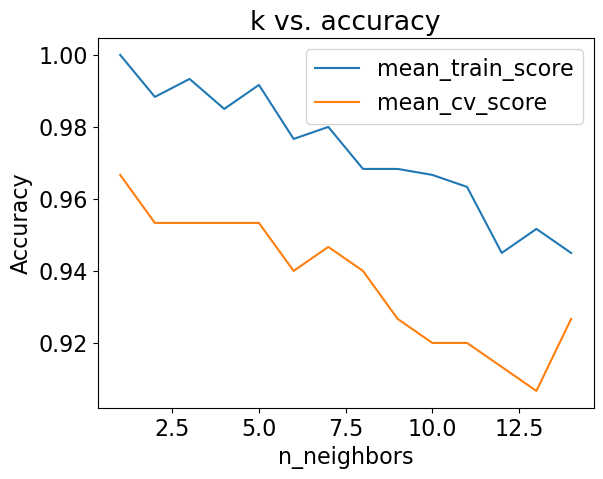

In [22]:
results_df[['mean_train_score', 'mean_cv_score']].plot(ylabel='Accuracy', title="k vs. accuracy");

In [23]:
best_k = n_neighbors[np.argmax(results_df['mean_cv_score'])]
best_k

1

Is SVC performing better than k-NN? 

In [24]:
C_values = np.logspace(-1, 2, 4)
cv_scores = []
train_scores = []

for C_val in C_values:
    print('C = ', C_val)
    svc = SVC(C=C_val)
    scores = cross_validate(svc, Z_train, y_train, return_train_score=True)
    cv_scores.append(scores['test_score'].mean())
    train_scores.append(scores['train_score'].mean())    

C =  0.1
C =  1.0
C =  10.0
C =  100.0


In [25]:
results_df = pd.DataFrame({"cv": cv_scores, 
                           "train": train_scores},index = C_values)
results_df

,cv,train
0.1,0.973333,0.993333
1.0,1.000000,1.000000
10.0,1.000000,1.000000
100.0,1.000000,1.000000


In [26]:
best_C = C_values[np.argmax(results_df['cv'])]
best_C

np.float64(1.0)

Let's go back to KNN and manually examine the nearest neighbours. 

What are the nearest neighbors?

In [27]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors()
nn.fit(Z_train)

NearestNeighbors()

In [28]:
# You do not have to understand this code. 
def show_nearest_neighbors(test_idx, nn, Z, X, y):
    distances, neighs = nn.kneighbors([Z[test_idx]])
    neighbors = neighs.ravel()
    plt.figure(figsize=(2,2), dpi=80)
    query_img = X[test_idx].transpose(1, 2, 0)
    query_img = ((X[test_idx].transpose(1, 2, 0) + 1.0) * 0.5 * 255).astype(np.uint8)
    plt.title('Query image', size=12)
    plt.imshow(np.clip(query_img, 0, 255));
    plt.xticks(())
    plt.yticks(())    
    plt.show()
    
    fig, axes = plt.subplots(1, 5, figsize=(10,4), subplot_kw={'xticks':(), 'yticks':()})
    print('Nearest neighbours:')
    
    for ax, dist, img_ind in zip(axes.ravel(), distances.ravel(), neighbors):
        img = X_train[img_ind].transpose(1, 2, 0)
        img = ((X_train[img_ind].transpose(1, 2, 0) + 1.0) * 0.5 * 255).astype(np.uint8)
        ax.imshow(np.clip(img, 0, 255))
        ax.set_title('distance: '+ str(round(dist,3)), size=10 )
    plt.show()

In [29]:
test_idx = [1, 2, 32, 70, 4]
for idx in test_idx: 
    show_nearest_neighbors(idx, nn, Z_valid, X_valid, y_valid)

NameError: name 'Z_valid' is not defined

We can use $k$-NNs for more than just classifying images; we can also find the most similar examples in a dataset. You can see how this would be useful in recommendation systems. For instance, if a user is purchasing an item, you can find similar items in the dataset and recommend them to the user! 